<p> <b> Author</b> : Rhondene Wint </p>
Biostatistics  
Feb. 22 2018

<img src="hw2.JPG" width="600", height ="800"> 


In [1]:
import pandas as pd
import os 
import sys

In [2]:
#read in population group for each sample from panel file
geotable= pd.read_table(sys.argv[1], header=0, usecols = ['sample','pop'])
geogroup = geotable['pop'].unique() #stores all the populations

#extract all individual IDs
inds = geotable['sample'].unique()
ind_single = dict()
# individual:count dictionary
for ind in inds:
    ind_single[ind]=0

#generate a dictionary of population:individuals key:value pair
pop_dict = dict()
for group in geogroup:   
    sample = geotable[geotable['pop']==group]['sample'] 
    pop_dict[group] = sample  

pop_dict['variants']= {k:0 for (k,v) in pop_dict.items()}  #records total variants for each population; could be useful later 
pop_dict['seg_sites'] = {k:0 for (k,v) in pop_dict.items()}  #count number of segregating sites for eac population
pop_dict['site_tracker'] = {k:0 for (k,v) in pop_dict.items()} #tracks if the current chromosome position was already recorded as a singleton for that population


In [4]:
#search for population of a individual
def reverse_lookup(dic, value):
    for k in dic:
        if value in dic[k].values:
            return k

In [5]:
#read vcf line by line and record segregating sites per population
n=os.popen("gunzip -c chr21.vcf.gz | grep -c '##' ").readline()

#sys.stdin=  zcat chr21.vcf.gz file
    i =0;
    for line in sys.stdin:
        i+=1
        if (i == n):  
            col_ID = sys.stdin.readline().split('\t') 
            col_ID = col_ID[9:]  #Column heading. the ID labels of each individual starts here
        if i > n:
            row = sys.stdin.readline().split('\t')
            try:  #i got an index error for some reason when I ran the whole vcf file, but did not appear on subset of data
                
                if len(row[3])==1 and len(row[4])==1: #bi-allelic sites, a single allele in ref column and alt column 
                    row=row[9:]
                #reset trackers to zero before searching new chr position  
                    pop_dict['site_tracker'] = {k:0 for (k,v) in pop_dict['site_tracker'].items()} 
                    single_list=[]
                    for x in range(len(row)):  #could also do for col in row
                        if (row[x]=='0|1' or row[x]=='1|0' or row[x]=='1|1'):
                            pop = reverse_lookup(pop_dict,col_ID[x])  #returns population key of that variant
                            pop_dict['variants'][pop]+=1
                        #update segregating site if not yet done
                            if (pop_dict['site_tracker'][pop]==0 ):
                                pop_dict['seg_sites'][pop]+=1
                                pop_dict['site_tracker'][pop]+=1 #update tracker for that population
                          #determines if global singleton      
                        if (row[x]=='0|1' or row[x]=='1|0'):
                            if (len(single_list)<2):
                                single_list.append(col_ID[x])  #stores singleton's ID
                                
                    #a singleton is conditioned if only one heterozygote is present and all else is 0|0
                    if (len(single_list)==1):
                        ind_single[single_list[0]]+=1   #map the singleton to its ID
                                  
            except IndexError:   #for whatever reason, restart loop and move on to subsequent row
                continue 

Wall time: 18.4 s


In [ ]:
#could've converted the dicts directily to csv but want to avoid those fickle indexing issues
seg_sites = pd.DataFrame(list(pop_dict['seg_sites'].items()), columns=['Population', 'Seg_Sites'])
singletons = pd.DataFrame(list(ind_single.items()), columns = ['Population', 'No_Singleton'])
variants = pd.DataFrame(list(pop_dict['variants'].items()), columns = ['Population', 'No_Variants'])

#map individual variants to their population
singletons.sort_values(singletons.columns[0], inplace=True)
geotable.sort_values(geotable.columns[0], inplace=True)
singletons['Population'] = geotable['pop']

#clsuter outputs csv files for later visualisation in Jupyter Notebook
seg_sites.to_csv('seg_sites2.csv', sep=',', index=False)
singletons.to_csv('singletons3.csv', sep=',', index =False)
variants = pd.DataFrame(list(pop_dict['variants'].items()), columns = ['Population', 'No_Variant'])


# Plot Number of Global Singletons for Each Population 
# Plot Number of Segregating Sites for Each Population
I am going to recreate the right plot from <b>Figure 1b<b> from the 1000genomes paper.

<img src='fig1b.jpg' width ='800' height='800' >


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib notebook
matplotlib.get_backend()

'nbAgg'

In [4]:
seg_sites = pd.read_csv('seg_sites2.csv', header=0, delimiter=',')
singletons = pd.read_csv('singletons3.csv', header=0, delimiter=',')
variants = pd.read_csv('variants2.csv', header=0, delimiter=',')

In [32]:
seg_sites.Seg_Sites.max()

151424

In [8]:
singletons.sort_values(by=['No_Singleton'], inplace=True)
singletons.head(5)

,Population,No_Singleton
2503,GIH,0
2107,LWK,11
108,FIN,14
119,FIN,14
148,FIN,14


<IPython.core.display.Javascript object>


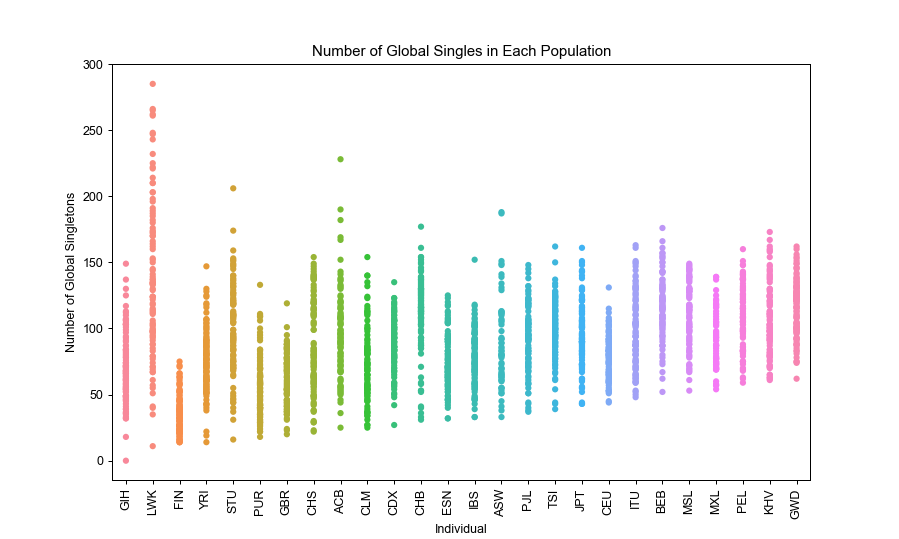

In [9]:
plt.figure(figsize=(10,6))
strips =sns.stripplot(x='Population', y='No_Singleton', data= singletons, size=5)  #store an array of all the strip objects

# Modify Graph Aesthetics
sns.set_style('white')
sns.set_palette("Paired", 4)
plt.style.use('seaborn-deep') 
plt.xticks(rotation = 'vertical')
plt.ylabel('Number of Global Singletons')
plt.xlabel('Individual')
plt.title('Number of Global Singles in Each Population')

<IPython.core.display.Javascript object>


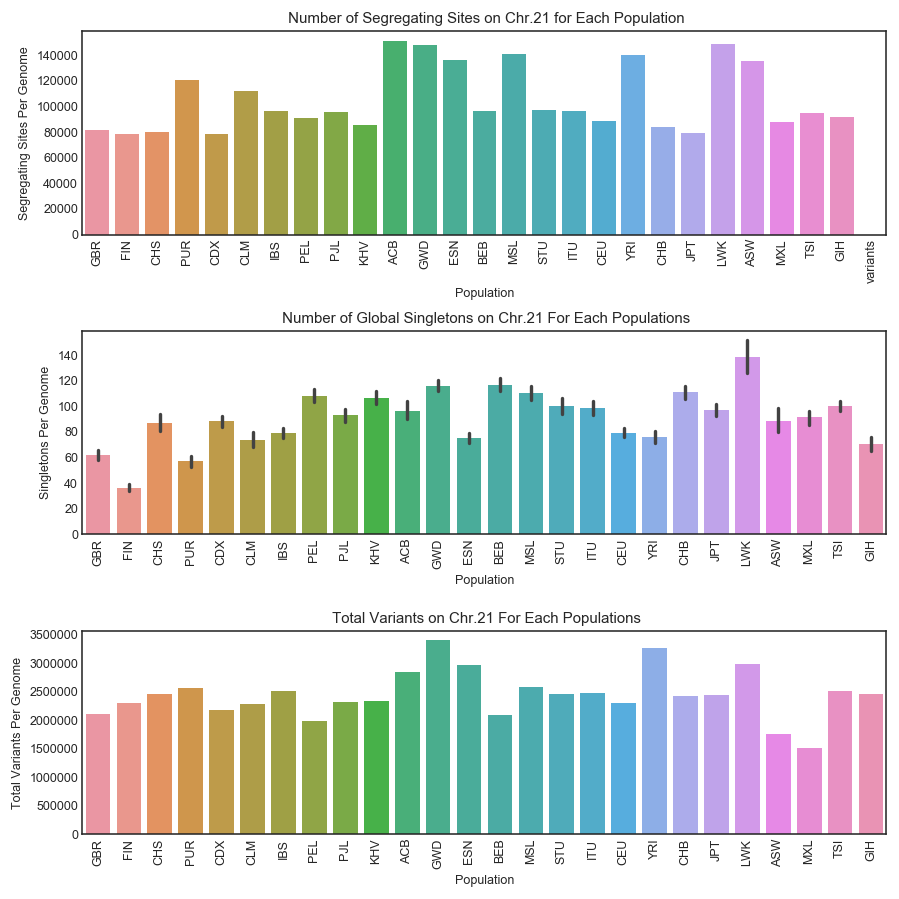

In [9]:
%matplotlib notebook


plt.figure(figsize=(10,10))

ax0 = plt.subplot2grid((9,3), (0,0), rowspan=3, colspan=3)                       
ax0=sns.barplot(x='Population', y='Seg_Sites', data= seg_sites)  #store an array of all the strips
ax0.set_ylabel("Segregating Sites Per Genome")
ax0.set_title(" Number of Segregating Sites on Chr.21 for Each Population")
for tick in ax0.get_xticklabels():
        tick.set_rotation('vertical')
      

ax1 = plt.subplot2grid((9,3), (3,0), rowspan=3, colspan=3)
ax1 = sns.barplot(x= 'Population', y='No_Singleton', data= singletons )
ax1.set_ylabel("Singletons Per Genome")
ax1.set_title(" Number of Global Singletons on Chr.21 For Each Populations")
for tick in ax1.get_xticklabels():
        tick.set_rotation('vertical')

ax2 = plt.subplot2grid((9,3), (6,0), rowspan=3, colspan=3) #starts at the second row and takes up 1st column to rest of column space 
ax2 = sns.barplot (x= 'Population', y='No_Variant', data= variants )
ax2.set_ylabel("Total Variants Per Genome")
ax2.set_title(" Total Variants on Chr.21 For Each Populations")
for tick in ax2.get_xticklabels():
        tick.set_rotation('vertical')


sns.set_style('white')
sns.set_palette("Paired", 6)
plt.tight_layout()

plt.show()


## Analysis

It was expected that the population with a high frequency of variants would also have more segregating sites and singletons, since they are most likely to produce variants. Both GWD and LWK (African) rank in the top 3 for the highest number of variants. LWK and GWD have the two highest number of singletons and segregating sites.  Conversely, European and North Asian countries (relatively homogenous populations) in general recorded low frequency of segregating sites and singletons


